# Week 6 - Classification models 

Hello again. Welcome to week 6! In this week, we will focus on how to model discrete response (or target) variables in STAN.

## Part 1: Logistic regression - Ancestral sampling

The usual imports...

In [84]:
import numpy as np
from matplotlib import pyplot as plt

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

The purpose of this first part is to make sure that you understand the modelling assumptions behind (Bayesian) logistic regression. A great way of doing that is by following the generative process of logistic regression and sample some data from the model! 

We assume that the inputs $\textbf{x}_n$ are always given. So lets make up some artificial $\textbf{x}$'s. For the sake of simplicity we assume $\textbf{x}_n$ to be a 2-dimensional vector:

In [85]:
# X's are fixed (2D points), sampled from a bivariate normal, centered at 0, with identitity covariance matrix
X = np.random.multivariate_normal(np.zeros(2),np.eye(2),size=20)
N, D = X.shape
print(X)

[[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]
 [ 1.57921282  0.76743473]
 [-0.46947439  0.54256004]
 [-0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024]
 [-1.72491783 -0.56228753]
 [-1.01283112  0.31424733]
 [-0.90802408 -1.4123037 ]
 [ 1.46564877 -0.2257763 ]
 [ 0.0675282  -1.42474819]
 [-0.54438272  0.11092259]
 [-1.15099358  0.37569802]
 [-0.60063869 -0.29169375]
 [-0.60170661  1.85227818]
 [-0.01349722 -1.05771093]
 [ 0.82254491 -1.22084365]
 [ 0.2088636  -1.95967012]
 [-1.32818605  0.19686124]]


We also need a sigmoid function. You can use one of implementations of the sigmoid available in various python packages, but we place our own implementation here in order to make everything transparent:

In [86]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Ok, now it is time to generate some data from a logistic regression model using ancestral sampling in Python. For this purpose, lets assume the following generative process:

1. Sample coefficients $\boldsymbol\beta \sim \mathcal{N}(\textbf{0}, \lambda\textbf{I})$
2. For $n=1 \dots N$
    3. Draw target variable $y_n \sim \mbox{Bernoulli}(\mbox{Sigmoid}(\textbf{x_n},\boldsymbol\beta))$

Can you do it? Save the targets in an array called "y"

Note: in order to keep this example the most trivial to implement (and possible to visualize below), we shall ignore the intercept (but only for this example!).

Make sure that you understand what is happening at each step! Print out the values of intermediate variables in the process to help you.

In [87]:
# sample coefficients (beta)
beta = np.random.normal(0,5,size=D)
print("beta:", beta)

# sample observations (y's)
y = np.zeros(N)
for n in range(N):
    p = sigmoid(np.dot(beta, X[n,:]))
    y[n] = np.random.binomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    print("%d: p=%.3f, y[n]=%.3f" % (n, p, y[n]))

beta: [3.6923329  0.85684141]
0: p=0.848, y[n]=1.000
1: p=0.976, y[n]=1.000
2: p=0.256, y[n]=0.000
3: p=0.998, y[n]=1.000
4: p=0.220, y[n]=0.000
5: p=0.108, y[n]=0.000
6: p=0.322, y[n]=1.000
7: p=0.001, y[n]=0.000
8: p=0.030, y[n]=0.000
9: p=0.010, y[n]=0.000
10: p=0.995, y[n]=1.000
11: p=0.275, y[n]=1.000
12: p=0.128, y[n]=0.000
13: p=0.019, y[n]=1.000
14: p=0.078, y[n]=0.000
15: p=0.346, y[n]=0.000
16: p=0.278, y[n]=0.000
17: p=0.880, y[n]=1.000
18: p=0.287, y[n]=0.000
19: p=0.009, y[n]=0.000


In [74]:
y = np.empty(len(X))
beta = np.random.normal(np.zeros(2), np.ones(2))
for n in range(len(X)):
    p = sigmoid(np.dot(beta, X[n,:]))
    y[n] = np.random.binomial(1, p)

Lets now visualize the data that you just generated, using different markers to distinguish between the two different classes:

In [101]:
beta
y==0

array([False, False,  True, False,  True,  True, False,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
        True,  True])

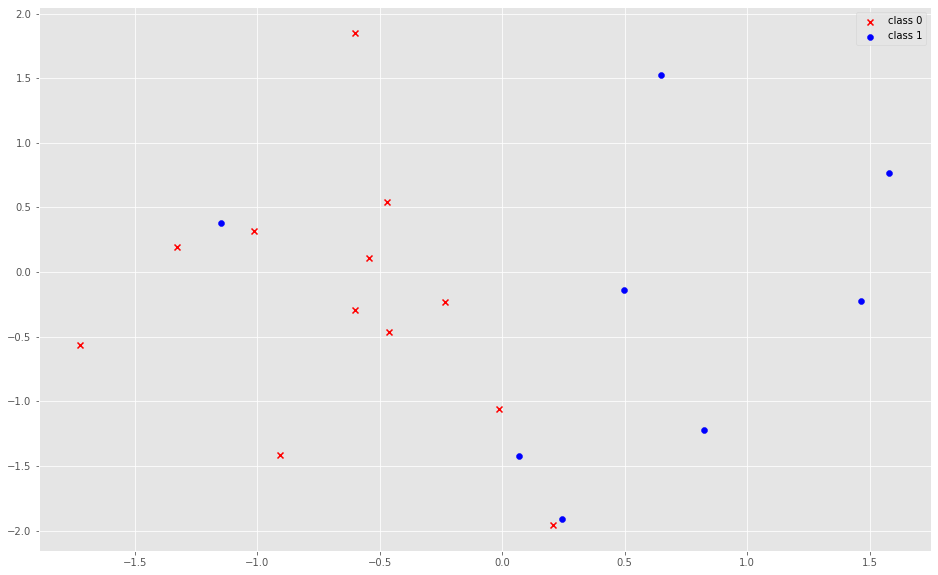

In [88]:
plt.scatter(X[y==0,0], X[y==0,1], marker='x', color="r")
plt.scatter(X[y==1,0], X[y==1,1], marker='o', color="b")
plt.legend(["class 0", "class 1"])
plt.show()

Since this is a low dimensional problem (2-D), we can actually visualize the decision boundary between the two classes quite nicely by computing the probability of a point belonging to class 1 for all points in a predefined grid. See if you can understand the code below:

In [103]:
xx1
xx1.ravel()
grid

array([[-2.  , -2.  ],
       [-2.  , -1.99],
       [-2.  , -1.98],
       ...,
       [ 1.99,  1.97],
       [ 1.99,  1.98],
       [ 1.99,  1.99]])

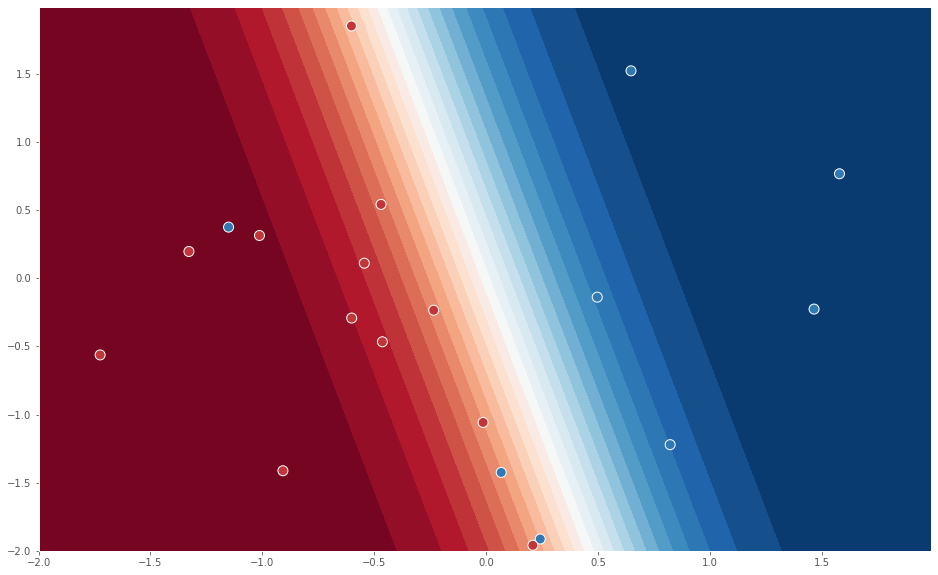

In [90]:
# create grid
xx1, xx2 = np.mgrid[-2:2:.01, -2:2:.01]
grid = np.c_[xx1.ravel(), xx2.ravel()]   #if you want to know what this is, inspect the "grid" variable,

# compute probabilities for all points in the grid
probs = sigmoid(np.dot(beta, grid.T))

# make plot
contour = plt.contourf(xx1, xx2, probs.reshape(xx1.shape), 25, cmap="RdBu", vmin=0, vmax=1)
plt.scatter(X[:,0], X[:, 1], c=y, s=100, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
plt.show()

Cool, right? Notice that you can have points in the "red" region being assined a blue target value (y), and vice-versa. Why is that? Make sure that you understand this.